In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [4]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy() # tilde means invrtsion: not isin
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()

print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  395164
Total transactions in test dataset:  95349


1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test

In [5]:
# Здесь у меня возник вопрос: какую агрегирующую фугкцию следует приенить при группровке данных(подразумевалась ли она)?
# Или же нужно было сделать сводую таблцу?
transactions_train.groupby('cl_id').nunique().head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
cl_id,,,,,,,,,,
0,2,1,5,0,1,4,5,3,1,1
1,4,1,23,0,2,54,85,3,1,1
5,4,1,34,0,3,81,118,7,1,1
10,3,1,36,0,1,240,303,7,1,1
11,4,1,39,0,2,78,188,2,1,1


2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи

2.Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)

? Не поняkа что нужно от этого пункта. Заменит значения target_flag и channel_type на уникальные?

Oбщая сумма транзакций по каждой из trx_category

In [6]:
transactions_train['id_trx_sum'] =  transactions_train.groupby(['cl_id','trx_category'])[['amount']]\
                                .transform(lambda x: x.sum())

Общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)

In [7]:
transactions_train['id_curr_sum'] =  transactions_train.groupby(['cl_id','currency'])[['amount']]\
                                .transform(lambda x: x.sum())

In [8]:
transactions_train.head(20)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,id_trx_sum,id_curr_sum
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.00,POS,0,0.0,122578.04,266693.13
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.00,POS,0,0.0,122578.04,266693.13
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.00,POS,0,0.0,122578.04,266693.13
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.00,POS,0,0.0,122578.04,266693.13
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.00,POS,0,0.0,122578.04,266693.13
10,01/09/2017,1,4111,NaN,978,30SEP17:00:00:00,17.10,POS,0,0.0,122578.04,884.91
11,01/08/2017,1,5814,NaN,810,02AUG17:00:00:00,450.00,POS,0,0.0,122578.04,266693.13
12,01/10/2017,1,5812,NaN,978,01OCT17:00:00:00,21.00,POS,0,0.0,122578.04,884.91
13,01/07/2017,1,5814,NaN,810,31JUL17:00:00:00,720.00,POS,0,0.0,122578.04,266693.13
14,01/10/2017,1,5814,NaN,810,08OCT17:00:00:00,5988.80,POS,0,0.0,122578.04,266693.13


Общая сумма транзакций по категориям MCC кодов 

In [8]:
transactions_train['id_MCC_sum'] =  transactions_train.groupby(['cl_id','MCC'])[['amount']]\
                                .transform(lambda x: x.sum())

Агрегация по дням недели

In [9]:
transactions_train['day_of_transaction'] = transactions_train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w'))

In [10]:
transactions_train['dayname'] = transactions_train['day_of_transaction'].apply(lambda x:'выходной' if x=='0' or x=='6' else 'будний')

In [11]:
transactions_train.head(20)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,id_trx_sum,id_curr_sum,id_MCC_sum,day_of_transaction,dayname
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0,7821.00,64383.00,5023.00,6,выходной
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,0.0,20000.00,64383.00,20000.00,4,будний
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,7821.00,64383.00,767.00,2,будний
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0,7821.00,64383.00,2031.00,6,выходной
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.00,C2C_OUT,0,0.0,36562.00,64383.00,36562.00,2,будний
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.00,POS,0,0.0,122578.04,266693.13,82441.17,1,будний
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.00,POS,0,0.0,122578.04,266693.13,82441.17,2,будний
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.00,POS,0,0.0,122578.04,266693.13,82441.17,1,будний
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.00,POS,0,0.0,122578.04,266693.13,82441.17,3,будний
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.00,POS,0,0.0,122578.04,266693.13,14629.46,3,будний


посмотреть распределения признаков

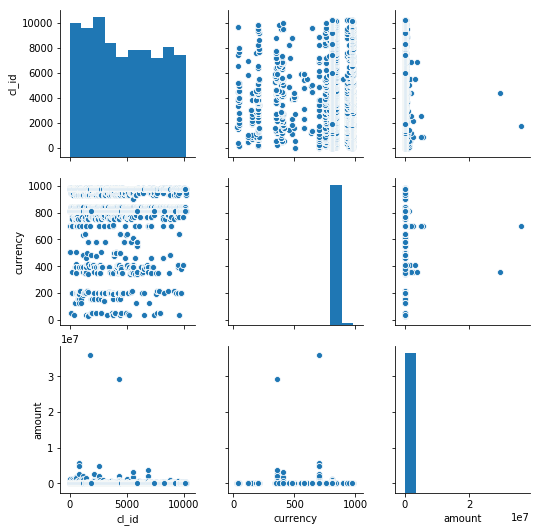

In [20]:
columns = ['cl_id', 'currency', 'amount']
sns.pairplot(transactions_train[columns])

In [40]:
#Число трат по дням недели
df1 = transactions_train.groupby(['day_of_transaction'])[['amount']].sum()

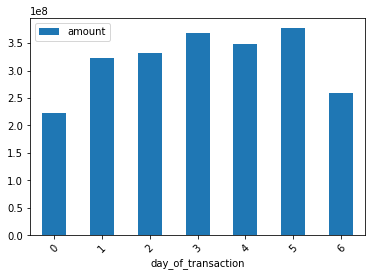

In [46]:
df1.plot(kind='bar', rot='45')

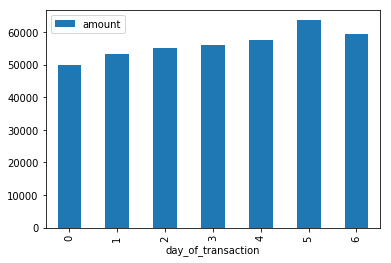

In [22]:
#Число транзакций по дням недели
tr = transactions_train.groupby(['day_of_transaction'])[['amount']].count()
tr.plot(kind='bar')

In [55]:
df2 =  transactions_train.groupby(['day_of_transaction','trx_category'])[['trx_category','amount']].sum()

In [56]:
df2.unstack('trx_category').head()

amount                                       \
trx_category          BACK_TRX       C2C_IN      C2C_OUT   CASH_ADV   
day_of_transaction                                                    
0                   2418914.55   7594627.68   5103462.04     286.00   
1                   2793575.47  10898567.07  11394303.49  150157.50   
2                   2724895.07  13426776.95  10316561.48   79195.21   
3                   3361336.84  11690931.19  11335374.57   40052.00   
4                   2681866.24  13264551.81  12573535.50  418880.00   

                                                                        \
trx_category               CAT      DEPOSIT           POS WD_ATM_OTHER   
day_of_transaction                                                       
0                    222888.61  31501810.00  1.329325e+08   3657748.10   
1                   4816222.15  62207580.70  9.511854e+07   5032899.40   
2                   1067442.53  59441715.01  1.007705e+08   5824750.45   
3                   3814899.87  57314253.80  1.348320e+08   5326263.30   
4                   5546253.67  65774583.95  1.063915e+08   6642888.29   

                                               
trx_category       WD_ATM_PARTNER  WD_ATM_ROS  
day_of_transaction                             
0                      16737000.0  22966100.0  
1                      44713350.0  86404400.0  
2                      44368150.0  93935000.0  
3                      45162450.0  95034200.0  
4                      42231850.0  92228500.0

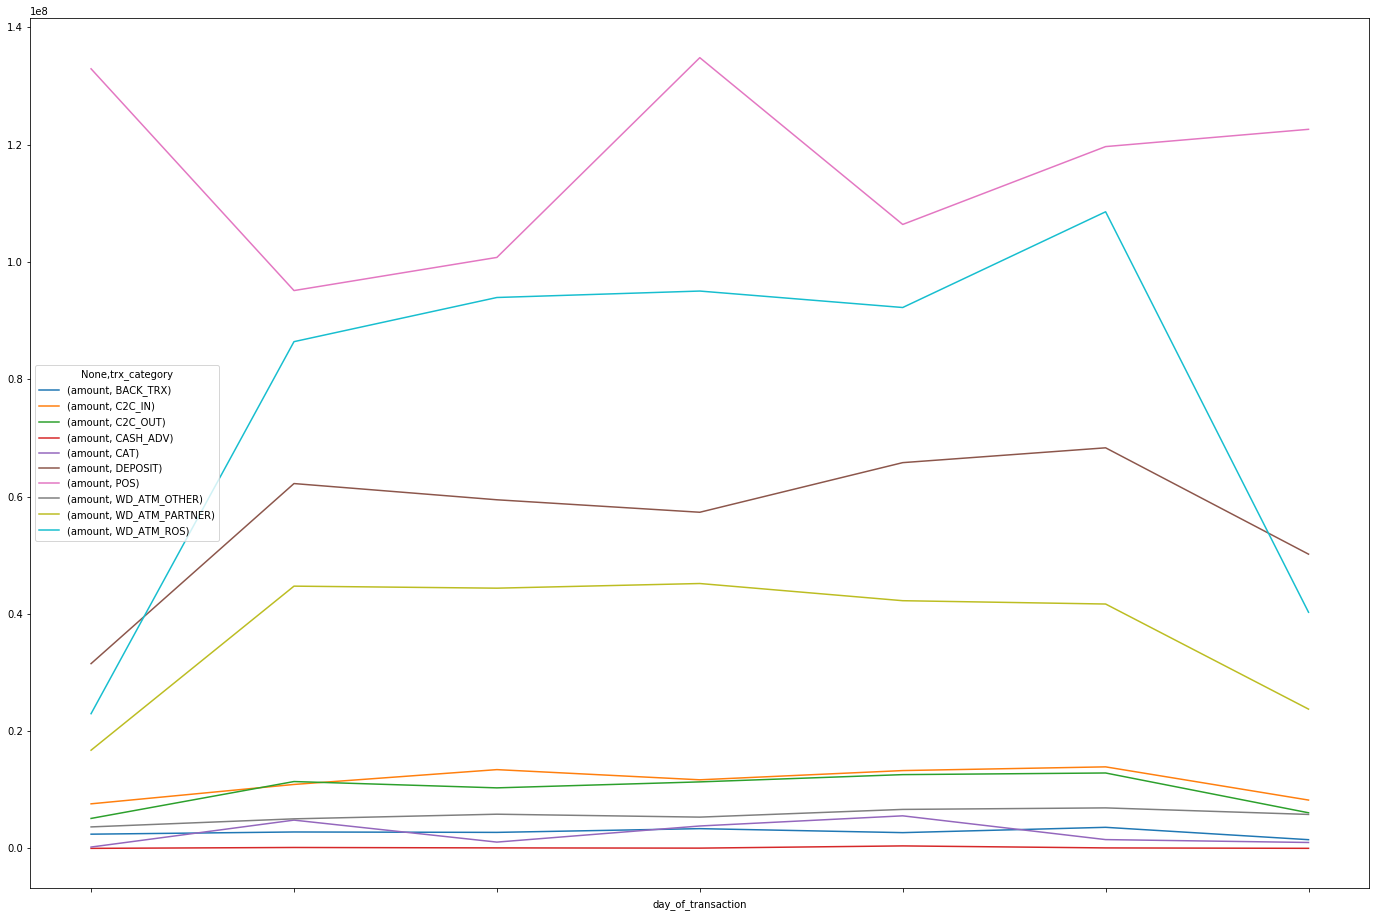

In [58]:
df2.unstack('trx_category').plot(figsize = [24,16])

In [75]:
#Популярные MCC
vc = transactions_train['MCC'].value_counts().head(11)
vc_list = vc.index.tolist()
vc_list

[5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921, 5331]

In [88]:
df3 =  transactions_train[transactions_train['MCC'].isin(vc_list)].groupby(['day_of_transaction','MCC'])[['amount']].sum()

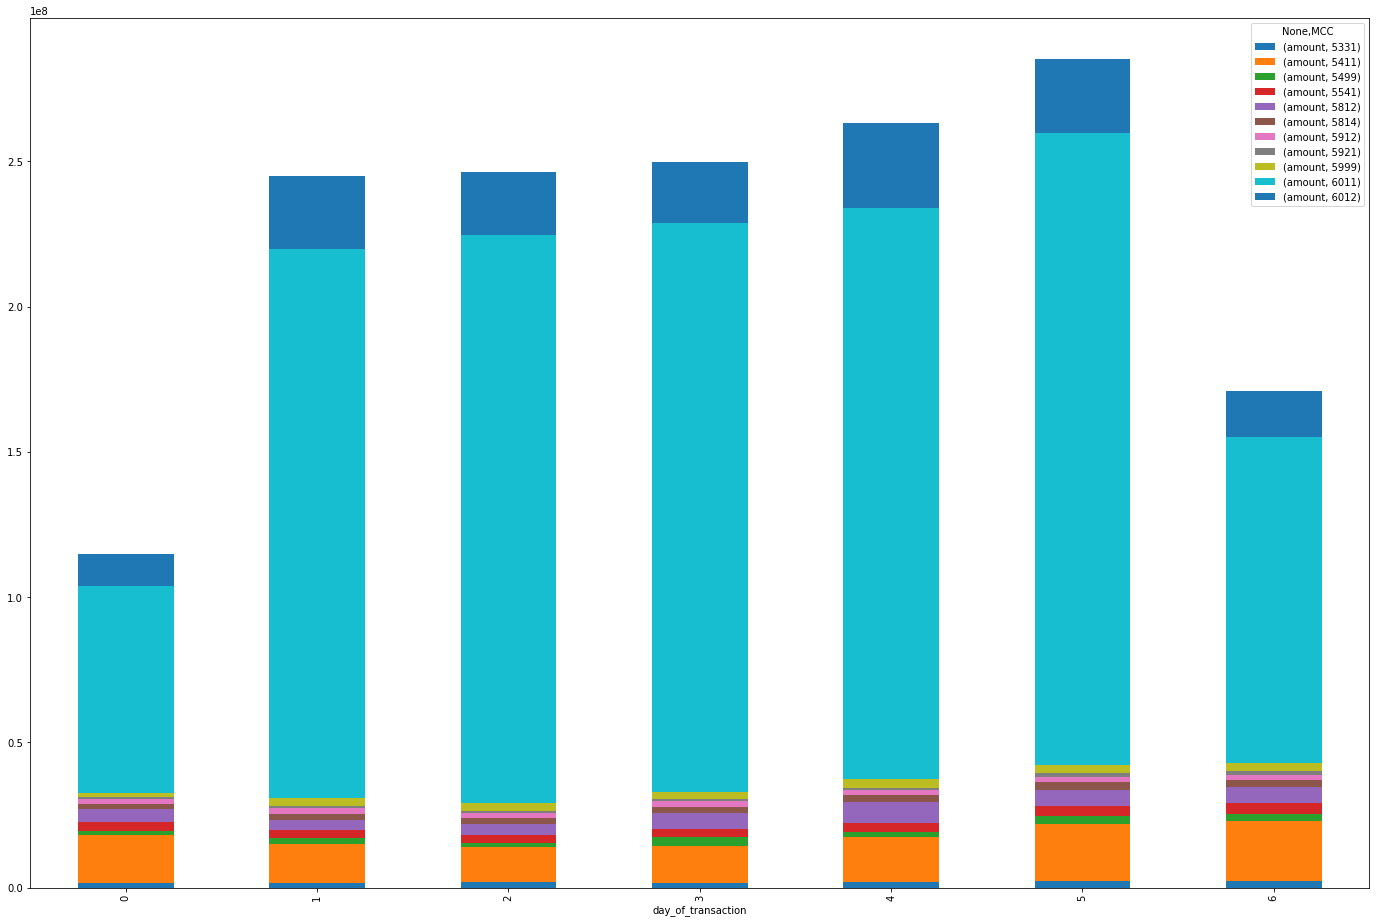

In [94]:
df3.unstack('MCC').plot(kind='bar',figsize = [24,16],stacked=True)

Помотреть активность клиентов по дням недели/времени

In [13]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [15]:
tr_day = transaction_by_day_count(transactions_train)

In [17]:
tr_day

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0
4,11,28.0,29.0,30.0,25.0,40.0,40.0,25.0
5,14,14.0,22.0,12.0,15.0,30.0,39.0,4.0
6,20,6.0,10.0,15.0,13.0,22.0,7.0,4.0
7,21,22.0,6.0,13.0,18.0,16.0,36.0,13.0
8,22,15.0,6.0,0.0,1.0,12.0,11.0,14.0
9,23,3.0,8.0,11.0,9.0,6.0,10.0,4.0


In [23]:
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [24]:
pd.set_option('display.max_columns',25)

In [26]:
tr_hour = transaction_by_hour_count(transactions_train)

In [29]:
tr_hour.set_index('cl_id')

hour_of_transaction,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
cl_id,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,12.0,5.0,6.0,27.0,7.0,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
11,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0
14,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
22,39.0,0.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
